In [52]:
import os, json
from tqdm import tqdm
from collections import defaultdict
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import shutil
import random
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Subset
from torch.utils.data import random_split
import torch.nn.functional as F

In [53]:
#Path
image_path = "images-trainval"
train_path = r"jsonl\train.jsonl"
info_path = "jsonl\info.json"

In [54]:
#Data process
with open(info_path, "r", encoding="utf-8") as f:
    info = json.load(f)
print("Loaded info.json. Examples:", type(info))

annotations = {}
data = []

with open(train_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Reading_train.jsonl"):
        item = json.loads(line)
        image_id = item.get("image_id") 
        image_file = os.path.join(image_path, f"{image_id}.jpg")
        if os.path.exists(image_file):
            data.append(item)
        else:
            print(f"There is no image {image_id}.jpg.")

Loaded info.json. Examples: <class 'dict'>


Reading_train.jsonl: 24290it [00:10, 2287.05it/s]


In [55]:
annotations = defaultdict(lambda: {
    "annotations": [],
    "ignore": [],
    "file_name": None,
    "height": None,
    "width": None
})

for item in data:
    image_id = item.get("image_id")
    
    for annotation in item.get("annotations", []):
        annotations[image_id]["annotations"].append(annotation)

    for i in item.get("ignore", []):
        annotations[image_id]["ignore"].append(i)

    annotations[image_id]["file_name"] = item.get("file_name")
    annotations[image_id]["height"] = item.get("height")
    annotations[image_id]["width"] = item.get("width")

print("Total images found in the file:", len(annotations))

Total images found in the file: 24290


In [56]:
#Mask

def Mask_Function(image_id):
    image_file_mask = os.path.join(image_path, f"{image_id}.jpg")
    image = cv2.imread(image_file_mask)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)

    for annotation in annotations[image_id]["annotations"]:
        for bbox_info in annotation:
            x, y, w, h = map(int, bbox_info["adjusted_bbox"])
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = min(width, x+w), min(height, y+h)
            mask[y1:y2, x1:x2] = 1

    return image, mask.astype(np.float32) 


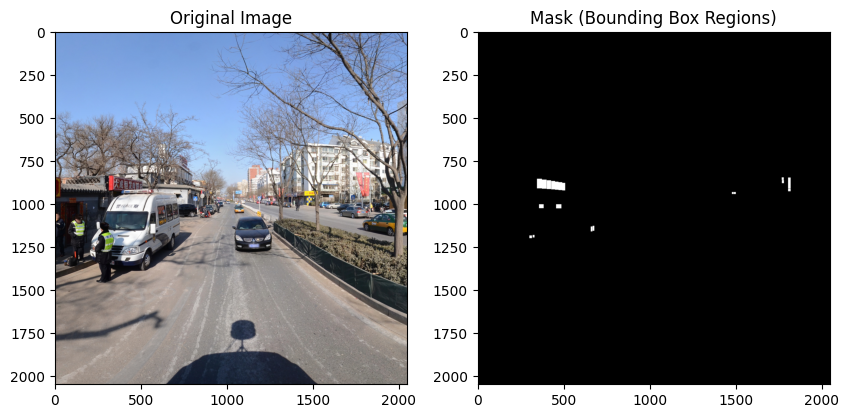

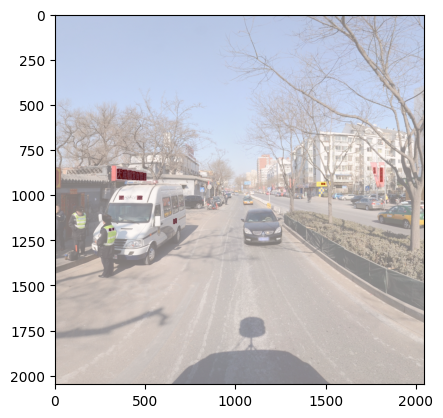

In [57]:
image_ids = list(annotations.keys())
random.shuffle(image_ids)

selected_size = 500
image_ids = image_ids[:selected_size]

train_split = image_ids[:int(0.7*len(image_ids))]
value_split = image_ids[int(0.7*len(image_ids)):int(0.85*len(image_ids))]
test_split  = image_ids[int(0.85*len(image_ids)):]

random.seed(42)
random.shuffle(image_ids)

image, mask = Mask_Function("0000189")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask (Bounding Box Regions)")
plt.show()

plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap="Reds")

In [ ]:
class Dataset1(Dataset):
    def __init__(self, image_ids, img_dir, annotations):
        self.image_ids = image_ids
        self.img_dir = img_dir
        self.annotations = annotations

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image, mask = Mask_Function(image_id)
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

In [59]:
class Dataset2(Dataset):
    def __init__(self, image_ids, img_dir, annotations, patch_size=128, stride=64, threshold=0.01, transform=None):
        self.patches = []
        self.patch_masks = []
        self.transform = transform

        self.img_dir = img_dir
        self.annotations = annotations

        for image_id in image_ids:
            image, mask = Mask_Function(image_id)
            h, w = image.shape[:2]

            for y in range(0, h - patch_size + 1, stride):
                for x in range(0, w - patch_size + 1, stride):
                    patch = image[y:y+patch_size, x:x+patch_size]
                    patch_mask = mask[y:y+patch_size, x:x+patch_size]

                    if patch_mask.sum() / (patch_size * patch_size) > threshold:
                        self.patches.append(patch)
                        self.patch_masks.append(patch_mask)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        patch_mask = self.patch_masks[idx]

        if self.transform:
            augmented = self.transform(image=patch, mask=patch_mask)
            patch = augmented['image']
            patch_mask = augmented['mask']

        patch = torch.tensor(patch, dtype=torch.float32).permute(2, 0, 1) / 255.0
        patch_mask = torch.tensor(patch_mask, dtype=torch.float32).unsqueeze(0)

        return patch, patch_mask


In [60]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [61]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = self.conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        self.conv_final = nn.Conv2d(64, out_channels, 1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        if d3.shape != e3.shape:
            d3 = F.interpolate(d3, size=e3.shape[2:])
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        if d2.shape != e2.shape:
            d2 = F.interpolate(d2, size=e2.shape[2:])
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        if d1.shape != e1.shape:
            d1 = F.interpolate(d1, size=e1.shape[2:])
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.conv_final(d1)
        return out

In [63]:
def evaluate_detection_model(model, dataloader, device, threshold=0.5):
    model.eval()
    
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()

            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_targets.extend(masks.cpu().numpy().reshape(-1))

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)

    intersection = np.logical_and(all_preds==1, all_targets==1).sum()
    union = np.logical_or(all_preds==1, all_targets==1).sum()
    iou = intersection / (union + 1e-6)

    dice = (2 * intersection) / (all_preds.sum() + all_targets.sum() + 1e-6)

    return accuracy,precision,recall,f1,dice,iou


In [64]:
train_dataset = Dataset2(train_split, image_path, annotations)
value_dataset = Dataset2(value_split, image_path, annotations)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
value_loader = DataLoader(value_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = CNN_Model().to(device)

In [66]:
def dice(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred_flat = pred.view(pred.size(0), -1)   
    target_flat = target.view(target.size(0), -1)

    intersection = (pred_flat * target_flat).sum(1)  
    union = pred_flat.sum(1) + target_flat.sum(1)  
    loss = 1 - (2 * intersection + smooth) / (union + smooth)

    return loss.mean()   

In [90]:
pos_weight = torch.tensor([15.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
num_epochs = 15  

In [91]:
for epoch in range(num_epochs):
    model_cnn.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(images)

        loss = criterion(outputs, masks) + 2*dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    model_cnn.eval()
    value_dice = 0.0
    count = 0
    with torch.no_grad():
        for value_images, value_masks in value_loader:
            value_images, value_masks = value_images.to(device), value_masks.to(device)
            preds = model_cnn(value_images)

            value_dice += dice(preds, value_masks)
            count += 1

    average_dice = value_dice / count

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Dice: {average_dice:.4f}")

torch.save(model_cnn.state_dict(), "model_cnn.pth")


Epoch 1/15, Train Loss: 2.5397, Dice: 0.3488
Epoch 2/15, Train Loss: 2.5341, Dice: 0.3096
Epoch 3/15, Train Loss: 2.5217, Dice: 0.3294
Epoch 4/15, Train Loss: 2.5103, Dice: 0.3684
Epoch 5/15, Train Loss: 2.5071, Dice: 0.3405
Epoch 6/15, Train Loss: 2.5010, Dice: 0.3829
Epoch 7/15, Train Loss: 2.4914, Dice: 0.3963
Epoch 8/15, Train Loss: 2.4830, Dice: 0.3541
Epoch 9/15, Train Loss: 2.4786, Dice: 0.3525
Epoch 10/15, Train Loss: 2.4708, Dice: 0.3842
Epoch 11/15, Train Loss: 2.4668, Dice: 0.3209
Epoch 12/15, Train Loss: 2.4613, Dice: 0.3582
Epoch 13/15, Train Loss: 2.4523, Dice: 0.3605
Epoch 14/15, Train Loss: 2.4495, Dice: 0.3679
Epoch 15/15, Train Loss: 2.4394, Dice: 0.3618


In [ ]:
accuracy_model_cnn,precision_model_cnn,recall_model_cnn,f1_model_cnn,dice_model_cnn,iou_model_cnn = evaluate_detection_model(model_cnn, value_loader, device)
print(f"Accuracy: {accuracy_model_cnn:.4f}")
print(f"Precision: {precision_model_cnn:.4f}")
print(f"Recall: {recall_model_cnn:.4f}")
print(f"F1 Score: {f1_model_cnn:.4f}")
print(f"Dice Score: {dice_model_cnn:.4f}")
print(f"IoU: {iou_model_cnn:.4f}")

Accuracy: 0.2360
Precision: 0.1483
Recall: 0.9860
F1 Score: 0.2578
Dice Score: 0.2578
IoU: 0.1479


In [92]:
model_unet = UNet().to(device)
optimizer_unet = torch.optim.Adam(model_unet.parameters(), lr=0.0001)
pos_weight_unet = torch.tensor([20]).to(device)
criterion_unet = nn.BCEWithLogitsLoss(pos_weight=pos_weight_unet)

num_epochs = 15

for epoch in range(num_epochs):
    model_unet.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device) 

        optimizer_unet.zero_grad()
        outputs = model_unet(images)

        loss = criterion_unet(outputs, masks) + 2*dice_loss(outputs, masks)
        loss.backward()
        optimizer_unet.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    model_unet.eval()
    value_dice = 0.0
    count = 0
    with torch.no_grad():
        for value_images, value_masks in value_loader:
            value_images, value_masks = value_images.to(device), value_masks.to(device)  
            preds = model_unet(value_images)

            value_dice += dice(preds, value_masks)  
            count += 1

    average_dice = value_dice / count

    print(f"UNet Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Dice: {average_dice:.4f}")

torch.save(model_unet.state_dict(), "model_unet.pth")

UNet Epoch 1/15, Train Loss: 3.3862, Dice: 0.2527
UNet Epoch 2/15, Train Loss: 3.1976, Dice: 0.3078
UNet Epoch 3/15, Train Loss: 2.9780, Dice: 0.3726
UNet Epoch 4/15, Train Loss: 2.7652, Dice: 0.2859
UNet Epoch 5/15, Train Loss: 2.5454, Dice: 0.3837
UNet Epoch 6/15, Train Loss: 2.3756, Dice: 0.4142
UNet Epoch 7/15, Train Loss: 2.1987, Dice: 0.3931
UNet Epoch 8/15, Train Loss: 2.0827, Dice: 0.5065
UNet Epoch 9/15, Train Loss: 1.8911, Dice: 0.4501
UNet Epoch 10/15, Train Loss: 1.7318, Dice: 0.5131
UNet Epoch 11/15, Train Loss: 1.5895, Dice: 0.5222
UNet Epoch 12/15, Train Loss: 1.4576, Dice: 0.5411
UNet Epoch 13/15, Train Loss: 1.3536, Dice: 0.4861
UNet Epoch 14/15, Train Loss: 1.2843, Dice: 0.4763
UNet Epoch 15/15, Train Loss: 1.1527, Dice: 0.5490


In [93]:
accuracy_model_unet,precision_model_unet,recall_model_unet,f1_model_unet,dice_model_unet,iou_model_unet= evaluate_detection_model(model_unet, value_loader, device)
print(f"Accuracy: {accuracy_model_unet:.4f}")
print(f"Precision: {precision_model_unet:.4f}")
print(f"Recall: {recall_model_unet:.4f}")
print(f"F1 Score: {f1_model_unet:.4f}")
print(f"Dice Score: {dice_model_unet:.4f}")
print(f"IoU: {iou_model_unet:.4f}")

Accuracy: 0.8900
Precision: 0.5714
Recall: 0.7295
F1 Score: 0.6409
Dice Score: 0.6409
IoU: 0.4715


In [ ]:
"""
chars = []
for image_id, information in annotations.items():
    for item in information["annotations"]:  
        for annotation in item:
            if annotation.get("is_chinese"):
                chars.append({
                    "image_id": image_id,
                    "char": annotation["text"],
                    "bbox": annotation["adjusted_bbox"],
                    "attributes": annotation["attributes"]
                })

print(f"Number of the chars:{len(chars)}")
print(chars[:1])
"""


In [ ]:
"""
count = 0
os.makedirs("chars", exist_ok=True)

for entry in tqdm(chars):
    image_id = entry["image_id"]
    char_label = entry["char"]
    bbox = entry["bbox"]

    image_path = os.path.join("images-trainval", f"{image_id}.jpg")
    image = cv2.imread(image_path)
    if image is None:
        print(f"{image_path} pass")
        continue

    x, y, w, h = map(int, bbox)
    x, y = max(0, x), max(0, y)
    w, h = max(1, w), max(1, h)
    char_img = image[y:y+h, x:x+w]

    save_dir = os.path.join("chars", char_label)
    os.makedirs(save_dir, exist_ok=True)
    img_name = f"{image_id}_{count}.jpg"
    save_path = os.path.join(save_dir, img_name)

    _, encoded_image = cv2.imencode(".jpg", char_img)
    encoded_image.tofile(save_path)

    count += 1

print(f"Tototal images: {count}")
"""

In [ ]:
"""
records = []

for char_label in os.listdir("chars"):
    folder = os.path.join("chars", char_label)
    if not os.path.isdir(folder):
        continue
    for img_name in os.listdir(folder):
        records.append({
            "image_path": os.path.join(folder, img_name),
            "label": char_label
        })

df = pd.DataFrame(records)
df.to_csv("chars_labels.csv", index=False, encoding="utf-8-sig")
print(f"Total chars and labels:{len(df)}")
"""

In [ ]:
"""
split_ratio = [0.8, 0.1, 0.1]
splits = ["train", "val", "test"]

for split in splits:
    os.makedirs(os.path.join("dataset", split), exist_ok=True)

def copy_image(src, dst):
    shutil.copy2(src, dst)

for char_label in tqdm(os.listdir("chars"), desc="Processing labels"):
    char_folder = os.path.join("chars", char_label)
    images = os.listdir(char_folder)
    random.shuffle(images)
    total = len(images)
    train_end = int(split_ratio[0]*total)
    val_end = train_end + int(split_ratio[1]*total)

    subsets = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, selected in subsets.items():
        split_dir = os.path.join("dataset", split, char_label)
        os.makedirs(split_dir, exist_ok=True)

        with ThreadPoolExecutor(max_workers=8) as executor:
            list(tqdm(
                executor.map(
                    lambda img: copy_image(os.path.join(char_folder, img),
                                           os.path.join(split_dir, img)),
                    selected
                ),
                total=len(selected),
                desc=f"{char_label}-{split}",
                leave=False
            ))
"""

In [5]:
class Chinese_CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(Chinese_CNN_Model, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
        )
        self.dropout = nn.Dropout(0.25)
        self.fc_layers = nn.Sequential(
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [38]:
empty_classes = []
for c in os.listdir("dataset/train"):
    if not os.listdir(os.path.join("dataset/train", c)):
        empty_classes.append(c)

print("Empty classes:", empty_classes[:10])
print("Total empty:", len(empty_classes))

Empty classes: []
Total empty: 0


In [ ]:
root_dir = "dataset"
for split in ["train", "val", "test"]:
    split_dir = os.path.join(root_dir, split)
    for char_label in os.listdir(split_dir):
        char_path = os.path.join(split_dir, char_label)
        if not os.listdir(char_path):  
            os.rmdir(char_path)
            print(f"Deleted empty folder: {char_path}")

In [76]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

min_images = 100

train_path = "dataset/train"
value_path   = "dataset/value"
test_path  = "dataset/test"

for root in [train_path, value_path, test_path]:
    for cls in os.listdir(root):
        cls_path = os.path.join(root, cls)
        if os.path.isdir(cls_path) and len(os.listdir(cls_path)) < min_images:
            shutil.rmtree(cls_path) 

train_dataset_identification = datasets.ImageFolder(root="dataset/train", transform=transform)
value_dataset_identification  = datasets.ImageFolder(root="dataset/value", transform=transform)
test_dataset_identification = datasets.ImageFolder(root="dataset/test", transform=transform)

train_loader_identification = DataLoader(train_dataset_identification, batch_size=64, shuffle=True)
value_loader_identification   = DataLoader(value_dataset_identification, batch_size=64, shuffle=False)
test_loader_identification  = DataLoader(test_dataset_identification, batch_size=64, shuffle=False)
num_classes = len(train_dataset_identification.classes)

train_classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path,d))]
value_classes   = [d for d in os.listdir(value_path)   if os.path.isdir(os.path.join(value_path,d))]
test_classes  = [d for d in os.listdir(test_path)  if os.path.isdir(os.path.join(test_path,d))]

print(f"Train classes: {len(train_classes)}")
print(f"Val classes: {len(value_classes)}")
print(f"Test classes: {len(test_classes)}")


Train classes: 970
Val classes: 179
Test classes: 182


In [80]:
selected_classes = train_dataset_identification.classes[:500]
print("Selected classes:", selected_classes)

selected_indices = [i for i, (_, label) in enumerate(train_dataset_identification.samples) if label < 500]
subset_dataset = Subset(train_dataset_identification, selected_indices)

total_len = len(subset_dataset)
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

train_dataset_selected, val_dataset_selected, test_dataset_selected = random_split(
    subset_dataset, [train_size, val_size, test_size]
)

train_loader_selected = DataLoader(train_dataset_selected, batch_size=32, shuffle=True)
val_loader_selected = DataLoader(val_dataset_selected, batch_size=32, shuffle=False)
test_loader_selected = DataLoader(test_dataset_selected, batch_size=32, shuffle=False)

num_classes_selected = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Chinese_CNN_Model(num_classes=num_classes_selected).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Selected classes: ['一', '丁', '七', '万', '三', '上', '下', '不', '与', '专', '世', '业', '东', '丝', '两', '严', '个', '中', '丰', '串', '临', '为', '主', '丽', '久', '义', '之', '乐', '乘', '九', '习', '乡', '书', '买', '了', '争', '事', '二', '于', '云', '五', '井', '亚', '交', '产', '享', '京', '亭', '亮', '人', '亿', '仁', '介', '从', '仓', '仙', '代', '以', '们', '件', '价', '任', '份', '企', '伊', '休', '众', '优', '会', '伟', '传', '伴', '位', '低', '住', '体', '佛', '作', '你', '佳', '供', '依', '便', '保', '信', '修', '值', '假', '做', '停', '健', '储', '儿', '元', '充', '先', '光', '克', '免', '党', '入', '全', '八', '公', '六', '兰', '共', '关', '兴', '具', '典', '养', '内', '再', '写', '军', '农', '冠', '冰', '冷', '准', '凉', '减', '凤', '凯', '出', '刀', '分', '列', '创', '利', '别', '到', '制', '刷', '券', '刻', '前', '副', '力', '办', '加', '务', '动', '助', '劳', '勤', '包', '化', '北', '匝', '区', '医', '十', '千', '升', '半', '华', '卓', '单', '卖', '南', '博', '卡', '卫', '印', '即', '厂', '厅', '压', '原', '厦', '厨', '县', '参', '及', '友', '双', '发', '受', '变', '口', '古', '可', '台', '右', '号', '司', '吃', '各', '合', '吉', '吊', '同', '名', '后', '

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_for_identification_slected = Chinese_CNN_Model(num_classes=num_classes_selected).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_for_identification_slected.parameters(), lr=0.001)

num_epochs = 25
for epoch in range(num_epochs):
    model_for_identification_slected.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader_selected:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_for_identification_slected(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(train_loader_selected)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {average_loss:.4f} | Accuracy: {accuracy:.2f}%")

KeyboardInterrupt: 

In [ ]:
def evaluate_chinese_cnn_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return acc, precision, recall, f1

In [ ]:
acc, precision, recall, f1 = evaluate_chinese_cnn_model(model_for_identification_slected, test_loader_selected, device)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")
print(f"Test F1-score: {f1*100:.2f}%")

Test Accuracy: 73.55%
Test Precision: 77.90%
Test Recall: 60.74%
Test F1-score: 66.23%


In [ ]:
#lr = 0.001 classes = 50
"""
Test Accuracy: 85.24%
Test Precision: 87.15%
Test Recall: 74.14%
Test F1-score: 78.97%
"""
#lr = 0.001 classes = 200
"""
Test Accuracy: 71.78%
Test Precision: 78.43%
Test Recall: 57.07%
Test F1-score: 63.69%
"""
"""
Test Accuracy: 74.84%
Test Precision: 78.59%
Test Recall: 62.63%
Test F1-score: 68.20%
"""
#lr = 0.001 classes = 200

In [ ]:
torch.save(model_for_identification_slected.state_dict(), "Chinese_CNN_Model_500.pth")